<a href="https://colab.research.google.com/github/ReemAlsharabi/KAUST-Academy/blob/main/Adv/Day2/DataLoadersMNIST_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will use the pytorch dataloader to load a custom dataset (MNIST Digits dataset in this case) from file.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import imageio as imo
import os
import pandas as pd

In [3]:
# Downloading dataset and storing in disk
!wget -O data.zip https://www.dropbox.com/sh/zbtnl65mtfvhpg7/AAD5SjeBToKkaYZ5A7gxw4yGa?dl=0

--2023-05-27 08:33:50--  https://www.dropbox.com/sh/zbtnl65mtfvhpg7/AAD5SjeBToKkaYZ5A7gxw4yGa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/zbtnl65mtfvhpg7/AAD5SjeBToKkaYZ5A7gxw4yGa [following]
--2023-05-27 08:33:51--  https://www.dropbox.com/sh/raw/zbtnl65mtfvhpg7/AAD5SjeBToKkaYZ5A7gxw4yGa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0220a31a0b5b8df49857560922.dl-eu.dropboxusercontent.com/zip_download_get/BgM1Ii3mUcWrsQ_5xR4ag3K7jt_Qx1Jn_ZRY2BE2R9hjnJ9qsB6LvZGmiaJptSWydw6xrTXRyBP9fWDygpPps5Y33IPlPkJ79Mk7GbVFuR08qA# [following]
--2023-05-27 08:33:51--  https://uc0220a31a0b5b8df49857560922.dl-eu.dropboxusercontent.com/zip_download_get/BgM1Ii3mUcWrsQ_5xR4ag3K7jt_Qx1Jn_ZRY2BE2R9hjnJ9qsB6LvZGmiaJptSWydw6xrTXRyBP9fWDygpPps5

In [4]:
# Extracting
!unzip data.zip
!gunzip mnist_train.tar.gz
!tar -xf mnist_train.tar

!gunzip mnist_test.tar.gz
!tar -xf mnist_test.tar

Archive:  data.zip
mapname:  conversion of  failed
 extracting: mnist_test.csv          
 extracting: mnist_train.csv         
 extracting: mnist_test.tar.gz       
 extracting: mnist_train.tar.gz      


In [5]:
!ls test/

000000-num7.png  002500-num2.png  005000-num3.png  007500-num8.png
000001-num2.png  002501-num3.png  005001-num9.png  007501-num3.png
000002-num1.png  002502-num3.png  005002-num9.png  007502-num8.png
000003-num0.png  002503-num2.png  005003-num8.png  007503-num6.png
000004-num4.png  002504-num1.png  005004-num4.png  007504-num7.png
000005-num1.png  002505-num7.png  005005-num1.png  007505-num0.png
000006-num4.png  002506-num0.png  005006-num0.png  007506-num0.png
000007-num9.png  002507-num7.png  005007-num6.png  007507-num1.png
000008-num5.png  002508-num6.png  005008-num0.png  007508-num2.png
000009-num9.png  002509-num4.png  005009-num9.png  007509-num3.png
000010-num0.png  002510-num1.png  005010-num6.png  007510-num4.png
000011-num6.png  002511-num3.png  005011-num8.png  007511-num5.png
000012-num9.png  002512-num8.png  005012-num6.png  007512-num6.png
000013-num0.png  002513-num7.png  005013-num1.png  007513-num7.png
000014-num1.png  002514-num4.png  005014-num1.png  007514-num8

In [6]:
!ls

data.zip	mnist_test.tar	 mnist_train.tar  test
mnist_test.csv	mnist_train.csv  sample_data	  train


## Datasets & Dataloaders

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

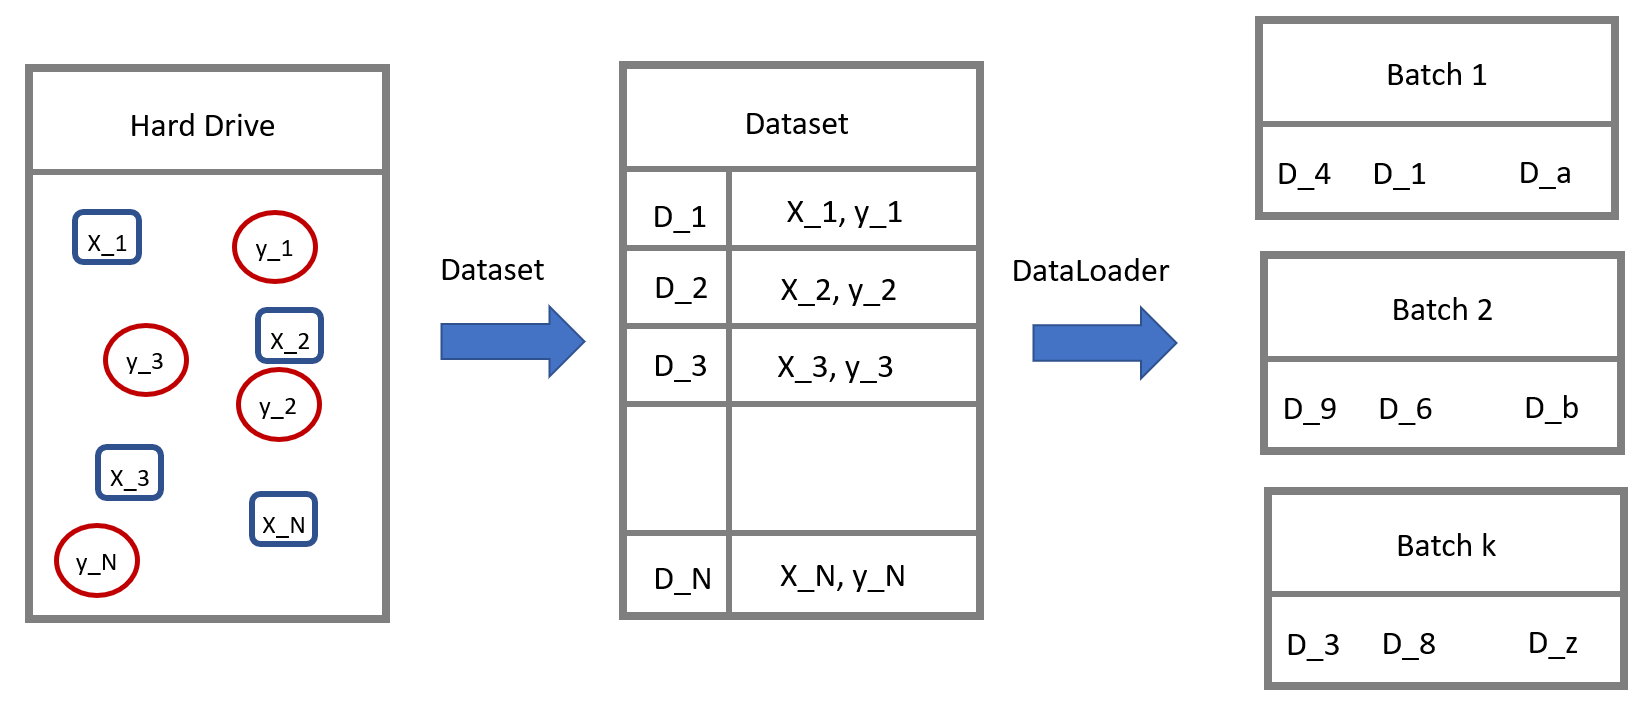

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

*   `__len__` so that len(dataset) returns the size of the dataset.

*   `__getitem__` to support the indexing such that `dataset[i]` can be used to get $i$th sample.

With pytorch dataloaders we can easily load, batch, distribute a pytorch dataset. Read more about pytorch dataloaders [here](https://pytorch.org/docs/stable/data.html)

We have download MNIST Dataset with the code above. Your task is to read the images and the corresponding labels and write your own data loader with data augmentation.

Note: we have two version of the MNIST dataset: version 1: The images are in a csv file with both the label and the image data in the columns of the csv file (the csv file is headerless). version 2: The images are png files with the label in the name of the image, e.g. an image of digit 9, where the file name if 2309 will be saved as 2309-num9.png.

In [8]:

class MyDataset(Dataset):
  def __init__(self, dataPath):
    super().__init__()
    self.path = dataPath
    self.files = os.listdir(self.path)

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    im = imo.imread(f"{self.path}{self.files[idx]}")
    dims = im.shape
    if len(dims)>2:
      im = np.transpose(im, (2,0,1))
    else:
      im = np.reshape(im, (1, dims[0], dims[1]))

    label = int(self.files[idx][-5])

    return (im,label)

In [9]:
dataset = MyDataset("train/")

<ipython-input-8-d0788f800319>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imo.imread(f"{self.path}{self.files[idx]}")


Text(0.5, 1.0, '5')

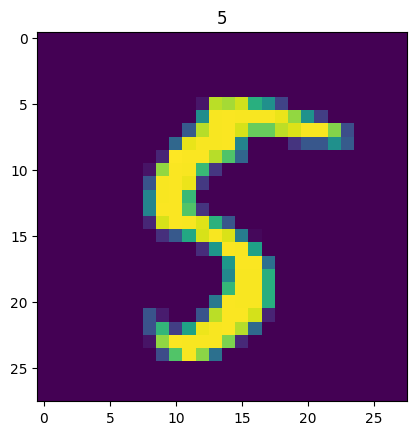

In [10]:
ind = 0

plt.imshow(dataset[ind][0][0,:,:])
plt.title(dataset[ind][1])

In [12]:
train_loader = DataLoader(dataset, batch_size = 64, shuffle = True)

In [14]:
tl = iter(train_loader)
batch = next(tl)

print(batch[0].shape)

torch.Size([64, 1, 28, 28])


<ipython-input-8-d0788f800319>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imo.imread(f"{self.path}{self.files[idx]}")


In [15]:
data = pd.read_csv("mnist_train.csv", header = None).to_numpy()

In [16]:
data

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [8, 0, 0, ..., 0, 0, 0]])